In [2]:
## import libraries
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import time

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import cv2

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.utils.vis_utils import plot_model

data source: https://www.kaggle.com/datasets/samaneheslamifar/facial-emotion-expressions

In [3]:
main_folder = '../input/facial-emotion-expressions/images'

labels_training = os.listdir(main_folder + "/train")
labels_testing = os.listdir(main_folder + "/validation")

print(f'Total Train Classes - {len(labels_training)} - {labels_training}')
print(f'Total Validation Classes - {len(labels_testing)} - {labels_testing}')

Total Train Classes - 7 - ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
Total Validation Classes - 7 - ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


In [4]:
# Creating the Pathlib PATH objects
path_train = Path("/kaggle/input/facial-emotion-expressions/images/train")
path_test = Path("/kaggle/input/facial-emotion-expressions/images/validation")

Prepare datasets


In [6]:
def generate_data_df(fol_path, dataset_name):
    print(f"Creating {dataset_name}")
    df = {"src_path":[],"label":[]}
    for label in os.listdir(fol_path):
            for src_path in glob.glob(f"{fol_path}/{label}/*"):
                df["src_path"].append(src_path)
                df["label"].append(label)
    df = pd.DataFrame(df)
    print("Done!")
    return df

In [7]:
df_train = generate_data_df(main_folder + "/train", "Training dataset")

Creating Training dataset
Done!


In [8]:
df_valid = generate_data_df(main_folder + "/validation", "Validation dataset")

Creating Validation dataset
Done!


In [9]:
df_train.head(5)

,src_path,label
0,../input/facial-emotion-expressions/images/tra...,surprise
1,../input/facial-emotion-expressions/images/tra...,surprise
2,../input/facial-emotion-expressions/images/tra...,surprise
3,../input/facial-emotion-expressions/images/tra...,surprise
4,../input/facial-emotion-expressions/images/tra...,surprise


In [10]:
df_valid.tail(5)

,src_path,label
7061,../input/facial-emotion-expressions/images/val...,happy
7062,../input/facial-emotion-expressions/images/val...,happy
7063,../input/facial-emotion-expressions/images/val...,happy
7064,../input/facial-emotion-expressions/images/val...,happy
7065,../input/facial-emotion-expressions/images/val...,happy


In [11]:
print(f"total training samples - {len(df_train)} \ntotal validation samples - {len(df_valid)}")

total training samples - 28821 
total validation samples - 7066


In [12]:
df_train.label.value_counts()

happy       7164
neutral     4982
sad         4938
fear        4103
angry       3993
surprise    3205
disgust      436
Name: label, dtype: int64

Visualization

In [13]:
def visualize_data(df,n_rows,n_cols):
    plt.figure(figsize=(15,16))
    for i in range(n_rows*n_cols):
        index = np.random.randint(0, len(df))
        img = cv2.imread(df.src_path[index])
        class_nm = df.label[index]
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img)
        plt.title(class_nm)
    plt.show()

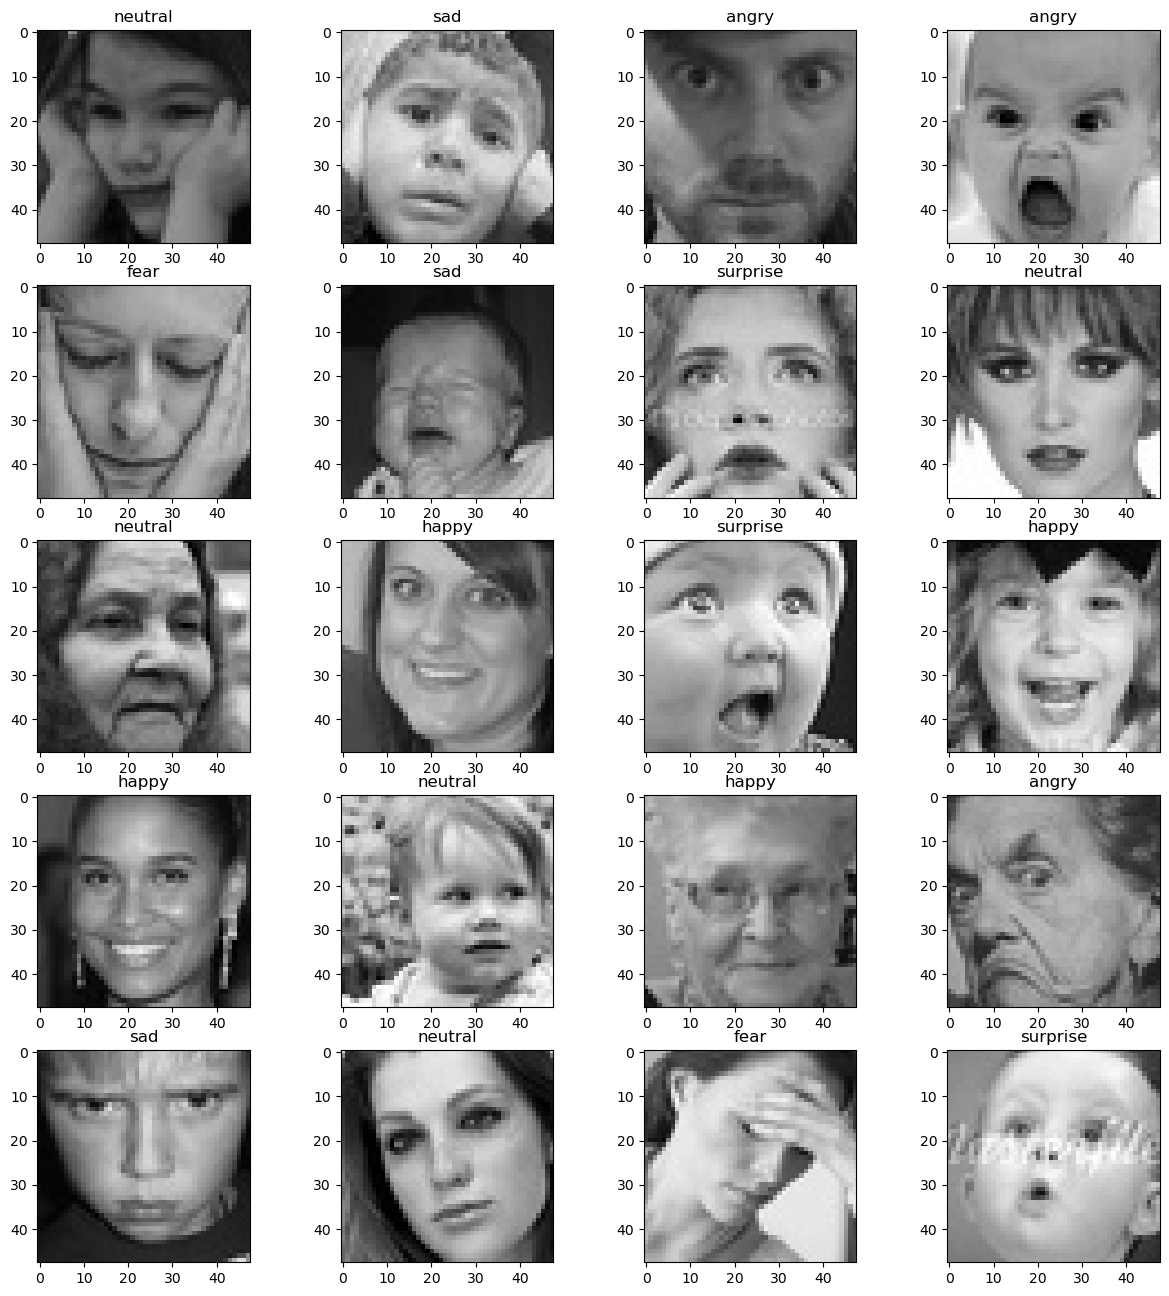

In [14]:
visualize_data(df_train, 5, 4)

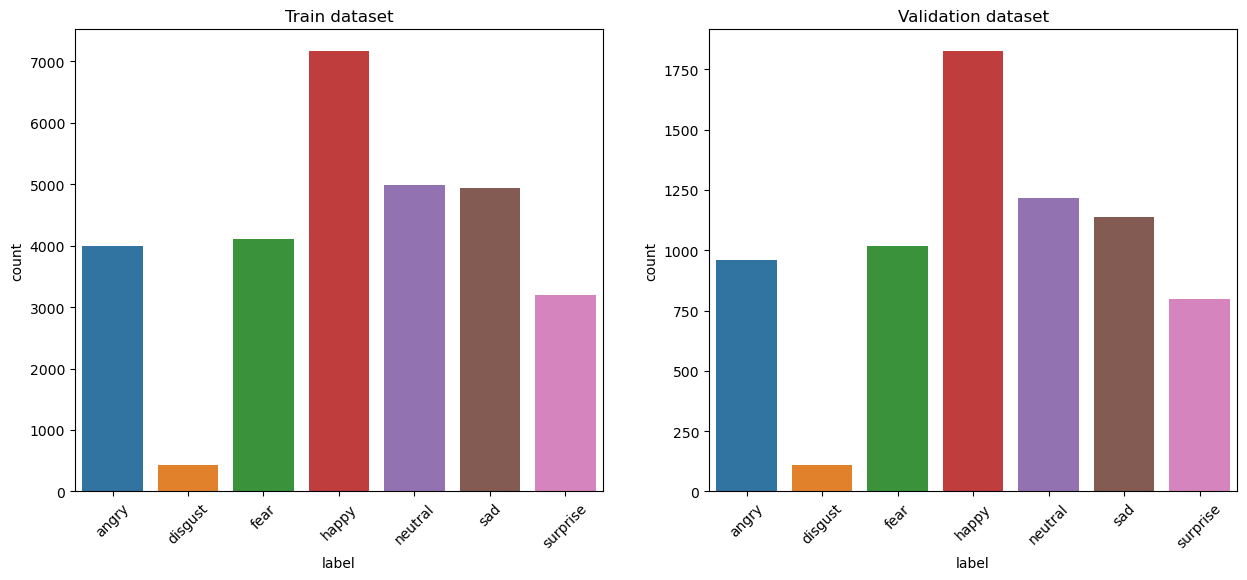

In [13]:
plt.figure(figsize=(15,6))
# training dataset
plt.subplot(1,2,1)
sns.countplot(data=df_train.sort_values("label"),x="label")
plt.title("Train dataset")
plt.xticks(rotation = 45)
# validation dataset
plt.subplot(1,2,2)
sns.countplot(data=df_valid.sort_values("label"),x="label")
plt.title("Validation dataset")
plt.xticks(rotation = 45)

plt.show()

In [14]:
from sklearn.preprocessing import LabelEncoder 

Le = LabelEncoder()
df_train["label"] = Le.fit_transform(df_train["label"])

df_train["label"].value_counts()

3    7164
4    4982
5    4938
2    4103
0    3993
6    3205
1     436
Name: label, dtype: int64

In [15]:
df_train.head()

,src_path,label
0,../input/facial-emotion-expressions/images/tra...,6
1,../input/facial-emotion-expressions/images/tra...,6
2,../input/facial-emotion-expressions/images/tra...,6
3,../input/facial-emotion-expressions/images/tra...,6
4,../input/facial-emotion-expressions/images/tra...,6


In [16]:
df_valid["label"] = Le.transform(df_valid["label"])

In [17]:
# one-hot encoding
labels_train = tf.keras.utils.to_categorical(df_train["label"])
labels_valid = tf.keras.utils.to_categorical(df_valid["label"])

In [18]:
labels_train[:10]

array([[0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [19]:
labels_train.sum(axis=0)

array([3993.,  436., 4103., 7164., 4982., 4938., 3205.], dtype=float32)

In [18]:
## extract features ----------
def get_features(items):
    feats = []
    for item in items:
        image = load_img(item, color_mode="grayscale")
        image = np.array(image)
        feats.append(image)
    feats = np.array(feats)
    feats = feats.reshape(len(feats), 48, 48, 1)
    return feats

In [19]:
start = time.time()

features_train = get_features(df_train['src_path'])

stop = time.time()
print(f"Feature extraction time for training: {round(stop - start,2)} seconds")

Feature extraction time for training: 238.24 seconds


In [20]:
start = time.time()

features_valid = get_features(df_valid['src_path'])

stop = time.time()
print(f"Feature extraction time for validation: {round(stop - start,2)} seconds")

Feature extraction time for validation: 49.69 seconds


In [21]:
## normalize the features in a scale of 0 to 1
x_train = features_train/255.0
x_valid = features_valid/255.0

In [22]:
perf_stats = {'model':[],'history':[],'batch_size':[],'epochs':[]}

In [25]:
## Create Model Architecture
## VERSION 1.0 ------- BEST
model = Sequential()
# convolutional layers
model.add(Conv2D(100, kernel_size=(3,3), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(200, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(400, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(800, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())

# fully connected layers
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(len(labels_train[0]), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

batch_size = 100
epochs = 70

# train the model
start = time.time()

history = model.fit(x=x_train, y=labels_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, labels_valid))

stop = time.time()
print(f"Model training time: {round(stop - start,2)} seconds")

perf_stats['model'].append(model)
perf_stats['history'].append(history)
perf_stats['batch_size'].append(batch_size)
perf_stats['epochs'].append(epochs)

Epoch 1/70
289/289 [==============================] - 7s 23ms/step - loss: 1.8214 - accuracy: 0.2408 - val_loss: 1.7931 - val_accuracy: 0.2583
Epoch 2/70
289/289 [==============================] - 6s 22ms/step - loss: 1.7446 - accuracy: 0.2781 - val_loss: 1.6082 - val_accuracy: 0.3813
Epoch 3/70
289/289 [==============================] - 7s 23ms/step - loss: 1.5512 - accuracy: 0.3917 - val_loss: 1.4048 - val_accuracy: 0.4626
Epoch 4/70
289/289 [==============================] - 6s 22ms/step - loss: 1.4283 - accuracy: 0.4457 - val_loss: 1.3117 - val_accuracy: 0.5033
Epoch 5/70
289/289 [==============================] - 6s 22ms/step - loss: 1.3558 - accuracy: 0.4770 - val_loss: 1.2673 - val_accuracy: 0.5139
Epoch 6/70
289/289 [==============================] - 6s 22ms/step - loss: 1.3119 - accuracy: 0.4962 - val_loss: 1.2140 - val_accuracy: 0.5320
Epoch 7/70
289/289 [==============================] - 7s 23ms/step - loss: 1.2690 - accuracy: 0.5166 - val_loss: 1.2156 - val_accuracy: 0.5355

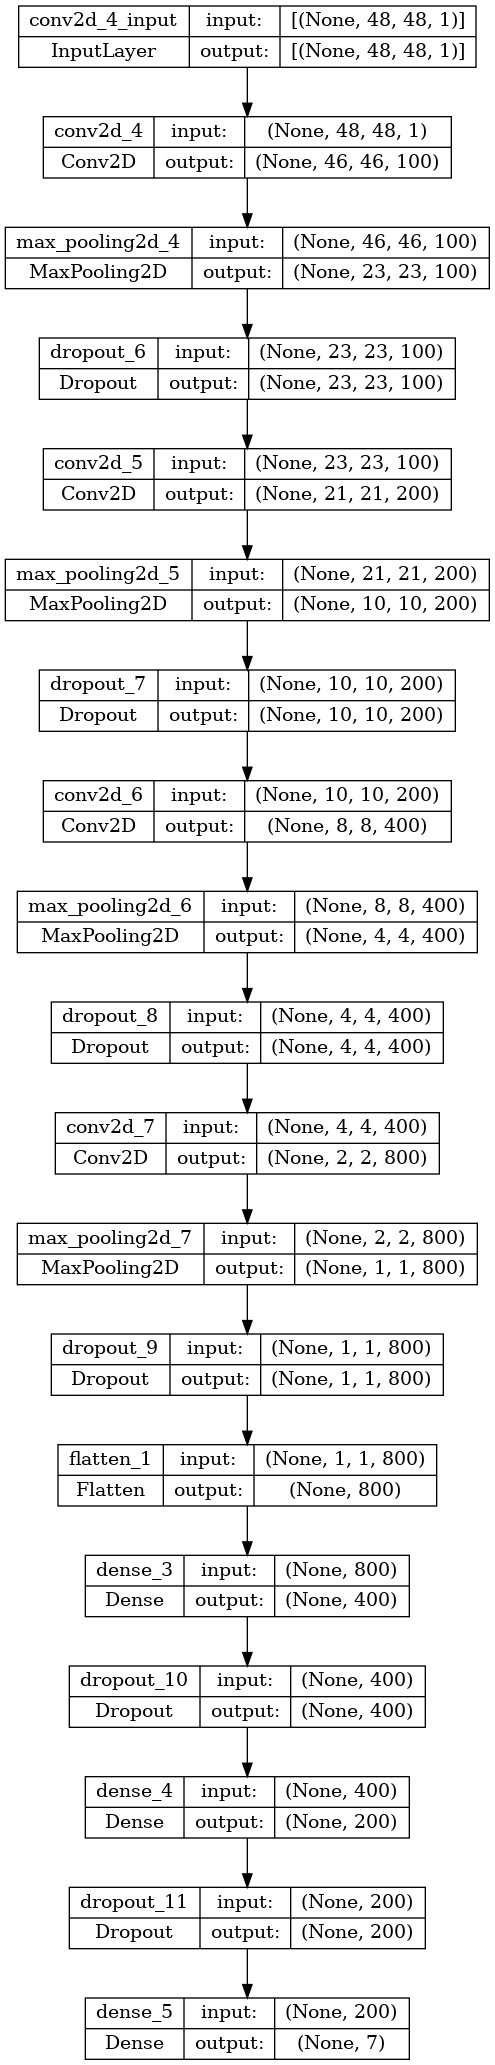

In [26]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

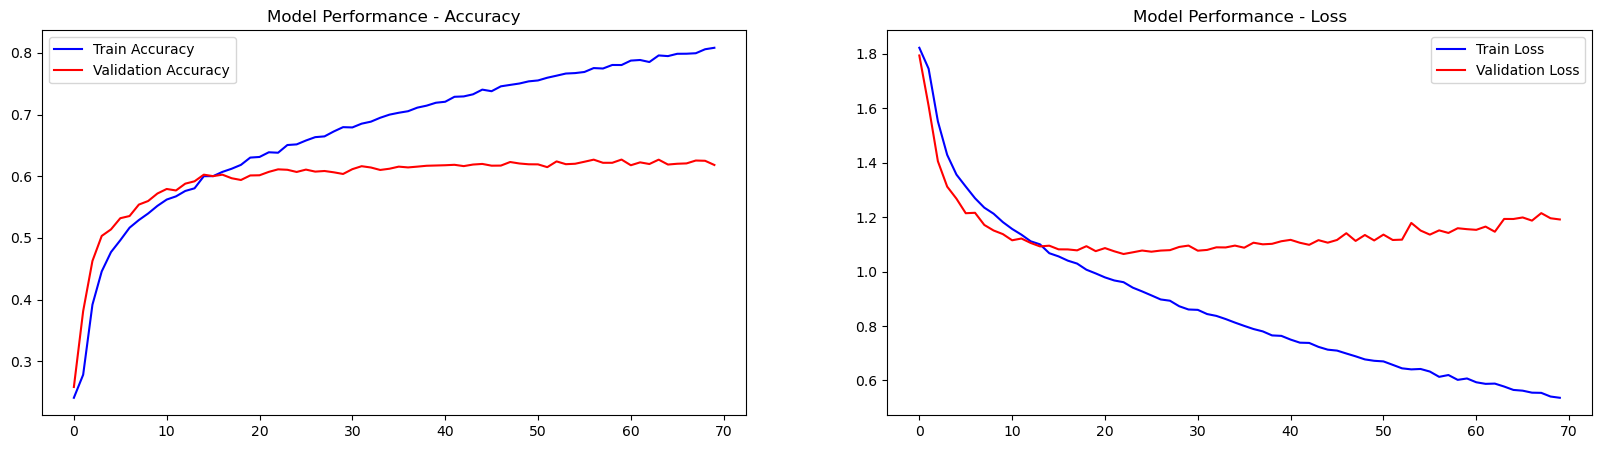

In [27]:
## plotting the train-test loss

accuracy = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
num_epochs = range(len(accuracy))

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(num_epochs, accuracy, 'b', label='Train Accuracy')
plt.plot(num_epochs, accuracy_val, 'r', label='Validation Accuracy')
plt.title('Model Performance - Accuracy')
plt.legend()

loss = history.history['loss']
loss_validation = history.history['val_loss']

plt.subplot(1,2,2)
plt.plot(num_epochs, loss, 'b', label='Train Loss')
plt.plot(num_epochs, loss_validation, 'r', label='Validation Loss')
plt.title('Model Performance - Loss')
plt.legend()

plt.show()

In [28]:
## Create Model Architecture
## VERSION 1.1 ---------
model = Sequential()
# convolutional layers
model.add(Conv2D(256, kernel_size=(3,3), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(1024, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
# output layer
model.add(Dense(len(labels_train[0]), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

batch_size = 256
epochs = 70

# train the model
start = time.time()

history = model.fit(x=x_train, y=labels_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, labels_valid))

stop = time.time()
print(f"Model training time: {round(stop - start,2)} seconds")

perf_stats['model'].append(model)
perf_stats['history'].append(history)
perf_stats['batch_size'].append(batch_size)
perf_stats['epochs'].append(epochs)

Epoch 1/70
113/113 [==============================] - 16s 129ms/step - loss: 1.8255 - accuracy: 0.2378 - val_loss: 1.7630 - val_accuracy: 0.2787
Epoch 2/70
113/113 [==============================] - 13s 117ms/step - loss: 1.6806 - accuracy: 0.3215 - val_loss: 1.5821 - val_accuracy: 0.3825
Epoch 3/70
113/113 [==============================] - 13s 117ms/step - loss: 1.5087 - accuracy: 0.4127 - val_loss: 1.4125 - val_accuracy: 0.4714
Epoch 4/70
113/113 [==============================] - 13s 117ms/step - loss: 1.4076 - accuracy: 0.4557 - val_loss: 1.3216 - val_accuracy: 0.4941
Epoch 5/70
113/113 [==============================] - 13s 117ms/step - loss: 1.3355 - accuracy: 0.4880 - val_loss: 1.2619 - val_accuracy: 0.5164
Epoch 6/70
113/113 [==============================] - 13s 117ms/step - loss: 1.2941 - accuracy: 0.4985 - val_loss: 1.2311 - val_accuracy: 0.5300
Epoch 7/70
113/113 [==============================] - 13s 117ms/step - loss: 1.2508 - accuracy: 0.5208 - val_loss: 1.1926 - val_ac

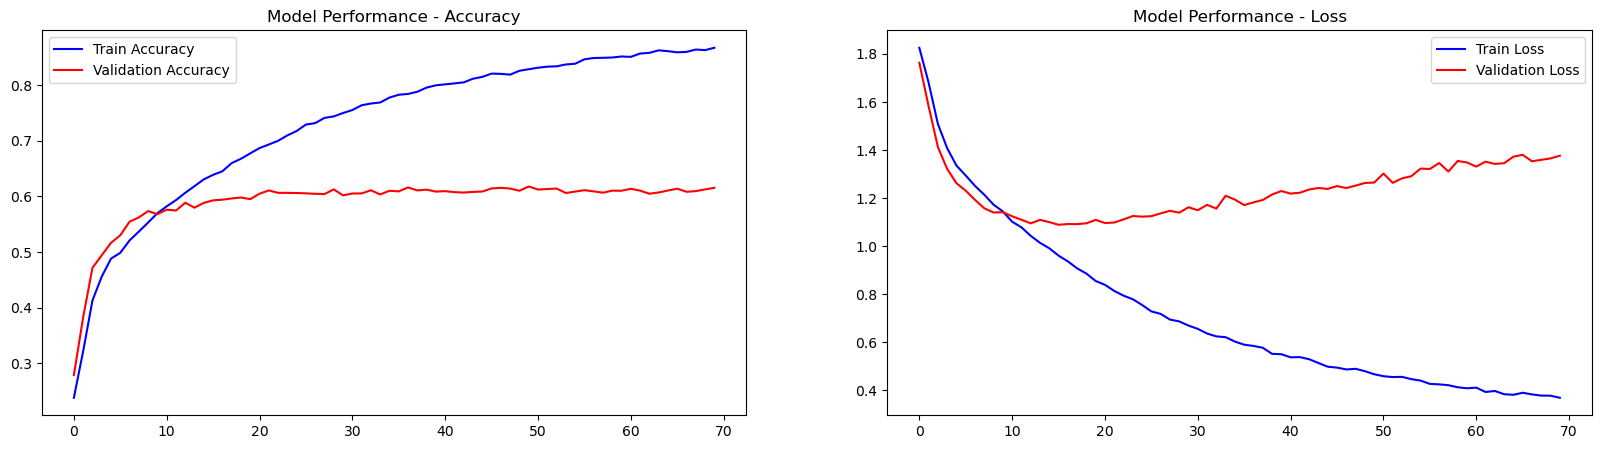

In [29]:
## plotting the train-test loss

accuracy = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
num_epochs = range(len(accuracy))

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(num_epochs, accuracy, 'b', label='Train Accuracy')
plt.plot(num_epochs, accuracy_val, 'r', label='Validation Accuracy')
plt.title('Model Performance - Accuracy')
plt.legend()

loss = history.history['loss']
loss_validation = history.history['val_loss']

plt.subplot(1,2,2)
plt.plot(num_epochs, loss, 'b', label='Train Loss')
plt.plot(num_epochs, loss_validation, 'r', label='Validation Loss')
plt.title('Model Performance - Loss')
plt.legend()

plt.show()

In [30]:
## Create Model Architecture
model = Sequential()
# convolutional layers
model.add(Conv2D(200, kernel_size=(3,3), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(400, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(800, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(1600, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(800, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
# output layer
model.add(Dense(len(labels_train[0]), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

batch_size = 200
epochs = 50

# train the model
start = time.time()

history = model.fit(x=x_train, y=labels_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, labels_valid))

stop = time.time()
print(f"Model training time: {round(stop - start,2)} seconds")

perf_stats['model'].append(model)
perf_stats['history'].append(history)
perf_stats['batch_size'].append(batch_size)
perf_stats['epochs'].append(epochs)

Epoch 1/50
145/145 [==============================] - 16s 98ms/step - loss: 1.8246 - accuracy: 0.2410 - val_loss: 1.8133 - val_accuracy: 0.2583
Epoch 2/50
145/145 [==============================] - 13s 93ms/step - loss: 1.8133 - accuracy: 0.2476 - val_loss: 1.7898 - val_accuracy: 0.2587
Epoch 3/50
145/145 [==============================] - 14s 95ms/step - loss: 1.7971 - accuracy: 0.2515 - val_loss: 1.7685 - val_accuracy: 0.2440
Epoch 4/50
145/145 [==============================] - 13s 93ms/step - loss: 1.7274 - accuracy: 0.2866 - val_loss: 1.6922 - val_accuracy: 0.3261
Epoch 5/50
145/145 [==============================] - 14s 93ms/step - loss: 1.6463 - accuracy: 0.3469 - val_loss: 1.5188 - val_accuracy: 0.4026
Epoch 6/50
145/145 [==============================] - 13s 93ms/step - loss: 1.5470 - accuracy: 0.3985 - val_loss: 1.4170 - val_accuracy: 0.4551
Epoch 7/50
145/145 [==============================] - 14s 93ms/step - loss: 1.4762 - accuracy: 0.4266 - val_loss: 1.3808 - val_accuracy:

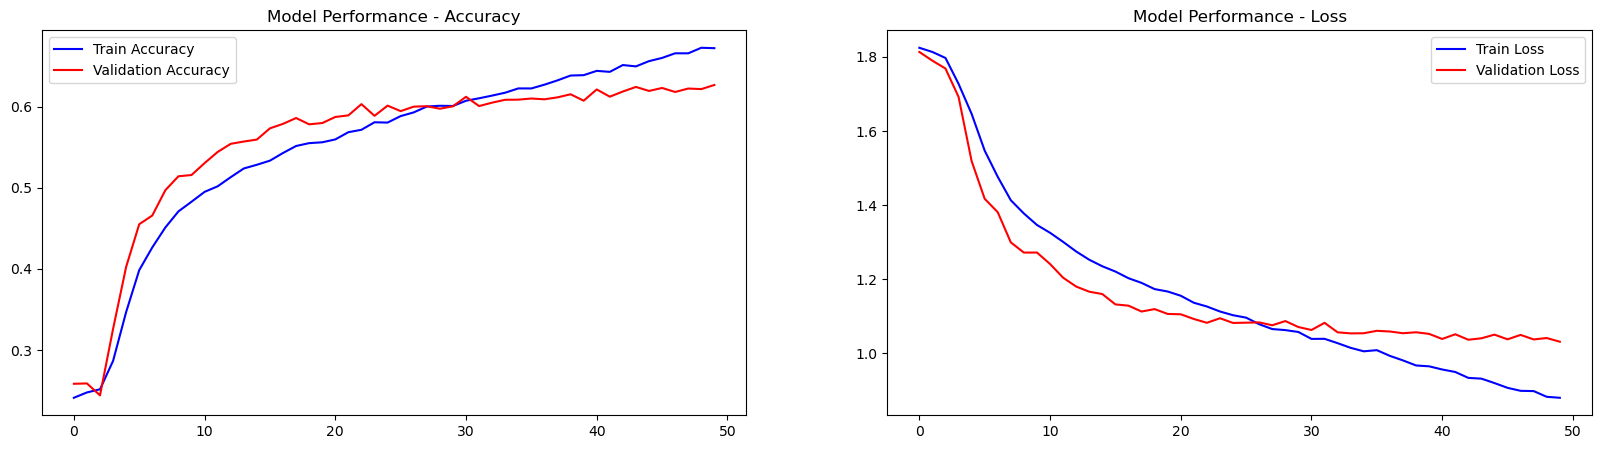

In [31]:
## plotting the train-test loss

accuracy = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
num_epochs = range(len(accuracy))

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(num_epochs, accuracy, 'b', label='Train Accuracy')
plt.plot(num_epochs, accuracy_val, 'r', label='Validation Accuracy')
plt.title('Model Performance - Accuracy')
plt.legend()

loss = history.history['loss']
loss_validation = history.history['val_loss']

plt.subplot(1,2,2)
plt.plot(num_epochs, loss, 'b', label='Train Loss')
plt.plot(num_epochs, loss_validation, 'r', label='Validation Loss')
plt.title('Model Performance - Loss')
plt.legend()

plt.show()

## EXPERIMENT - Trying after removing "disgust" class, because the class only contributes 1.5% to the dataset

In [35]:
df_train.label.value_counts()

3    7164
4    4982
5    4938
2    4103
0    3993
6    3205
1     436
Name: label, dtype: int64

Here, the class label 1 represents disgust. Let's remove it and observe the accuracy.

In [49]:
## removing disgust class, because it only contains ~1.5% of the data, which is not sufficient
df_train_new = df_train[df_train.label!=1].reset_index(drop=True)
df_valid_new = df_valid[df_valid.label!=1].reset_index(drop=True)

x_train_new = x_train[df_train.label!=1]
x_valid_new = x_valid[df_valid.label!=1]

In [50]:
df_train_new.label.value_counts()

3    7164
4    4982
5    4938
2    4103
0    3993
6    3205
Name: label, dtype: int64

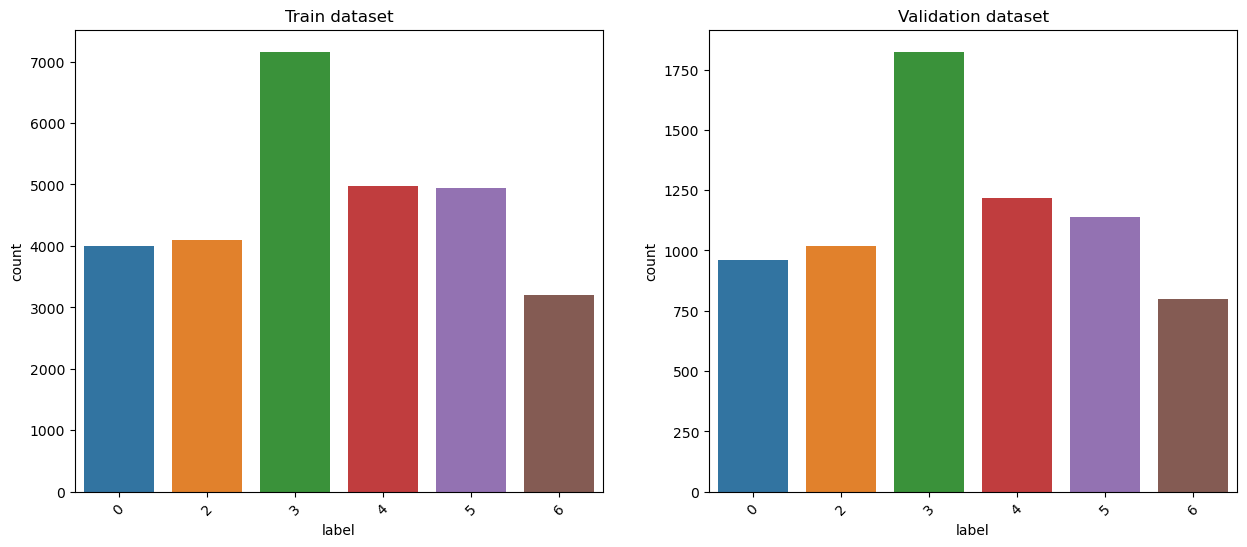

In [38]:
plt.figure(figsize=(15,6))
# train dataset
plt.subplot(1,2,1)
sns.countplot(data=df_train_new.sort_values("label"),x="label")
plt.title("Train dataset")
plt.xticks(rotation = 45)
# validation dataset
plt.subplot(1,2,2)
sns.countplot(data=df_valid_new.sort_values("label"),x="label")
plt.title("Validation dataset")
plt.xticks(rotation = 45)

plt.show()

In [51]:
Le2 = LabelEncoder()
df_train_new["label"] = Le2.fit_transform(df_train_new["label"])
df_valid_new["label"] = Le2.transform(df_valid_new["label"])

# one-hot encoding
labels_train_new = tf.keras.utils.to_categorical(df_train_new["label"])
labels_valid_new = tf.keras.utils.to_categorical(df_valid_new["label"])

In [57]:
df_train_new.shape, x_train_new.shape

((28385, 2), (28385, 48, 48, 1))

In [59]:
"""
feature extraction remains the same, hence not doing it again
"""

## Create Model Architecture
## VERSION 1.0 ------- BEST
model = Sequential()
# convolutional layers
model.add(Conv2D(100, kernel_size=(3,3), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(200, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(400, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(800, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

# fully connected layers
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
# output layer
model.add(Dense(len(labels_train_new[0]), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')


# train the model
start = time.time()

history = model.fit(x=x_train_new, y=labels_train_new, batch_size=batch_size, epochs=epochs, validation_data=(x_valid_new, labels_valid_new))

stop = time.time()
print(f"Model training time: {round(stop - start,2)} seconds")

perf_stats['model'].append(model)
perf_stats['history'].append(history)
perf_stats['batch_size'].append(batch_size)
perf_stats['epochs'].append(epochs)

Epoch 1/50
142/142 [==============================] - 7s 43ms/step - loss: 1.7631 - accuracy: 0.2509 - val_loss: 1.7479 - val_accuracy: 0.2624
Epoch 2/50
142/142 [==============================] - 5s 39ms/step - loss: 1.6963 - accuracy: 0.2786 - val_loss: 1.6040 - val_accuracy: 0.3188
Epoch 3/50
142/142 [==============================] - 5s 37ms/step - loss: 1.5141 - accuracy: 0.3905 - val_loss: 1.3674 - val_accuracy: 0.4574
Epoch 4/50
142/142 [==============================] - 5s 37ms/step - loss: 1.3859 - accuracy: 0.4473 - val_loss: 1.2618 - val_accuracy: 0.5111
Epoch 5/50
142/142 [==============================] - 6s 39ms/step - loss: 1.3126 - accuracy: 0.4834 - val_loss: 1.2175 - val_accuracy: 0.5298
Epoch 6/50
142/142 [==============================] - 5s 37ms/step - loss: 1.2594 - accuracy: 0.5072 - val_loss: 1.1827 - val_accuracy: 0.5389
Epoch 7/50
142/142 [==============================] - 5s 37ms/step - loss: 1.2266 - accuracy: 0.5223 - val_loss: 1.1368 - val_accuracy: 0.5593

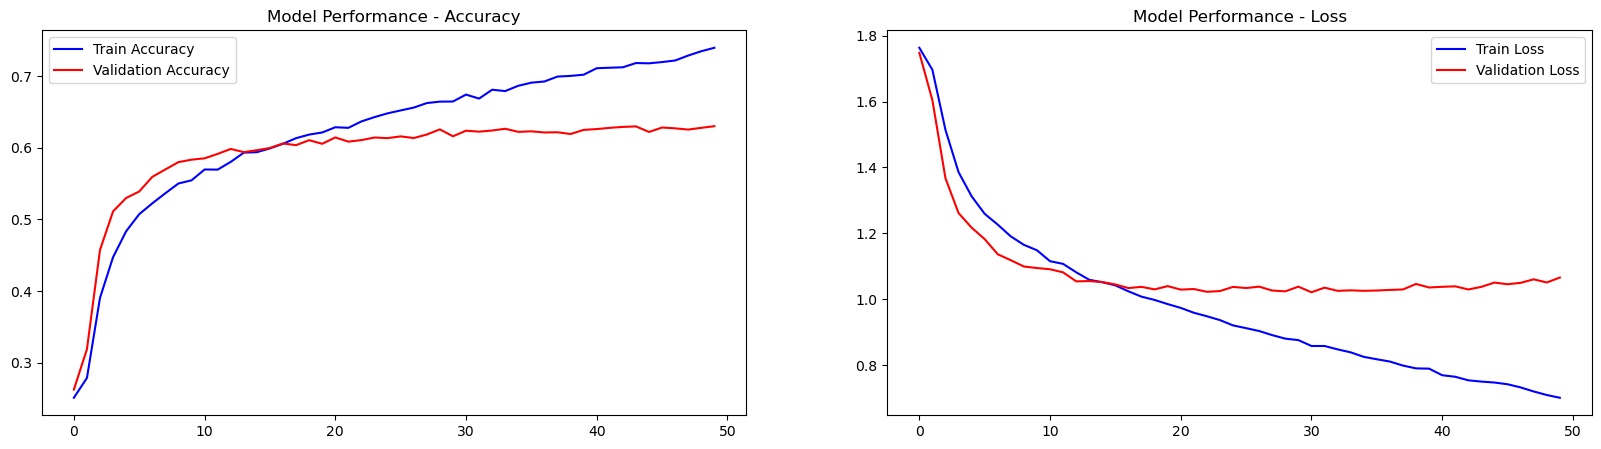

In [60]:
## plotting the train-test loss

accuracy = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
num_epochs = range(len(accuracy))

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(num_epochs, accuracy, 'b', label='Train Accuracy')
plt.plot(num_epochs, accuracy_val, 'r', label='Validation Accuracy')
plt.title('Model Performance - Accuracy')
plt.legend()

loss = history.history['loss']
loss_validation = history.history['val_loss']

plt.subplot(1,2,2)
plt.plot(num_epochs, loss, 'b', label='Train Loss')
plt.plot(num_epochs, loss_validation, 'r', label='Validation Loss')
plt.title('Model Performance - Loss')
plt.legend()

plt.show()

## Compare the best model

In [61]:
for item in perf_stats.items():
    print(item)

('model', [<keras.engine.sequential.Sequential object at 0x7f912149bd90>, <keras.engine.sequential.Sequential object at 0x7f90cc185110>, <keras.engine.sequential.Sequential object at 0x7f90882aee10>, <keras.engine.sequential.Sequential object at 0x7f8c1c3adb10>])
('history', [<keras.callbacks.History object at 0x7f90cd940e50>, <keras.callbacks.History object at 0x7f90cc148c90>, <keras.callbacks.History object at 0x7f9088275990>, <keras.callbacks.History object at 0x7f8c17458b10>])
('batch_size', [100, 256, 200, 200])
('epochs', [70, 70, 50, 50])


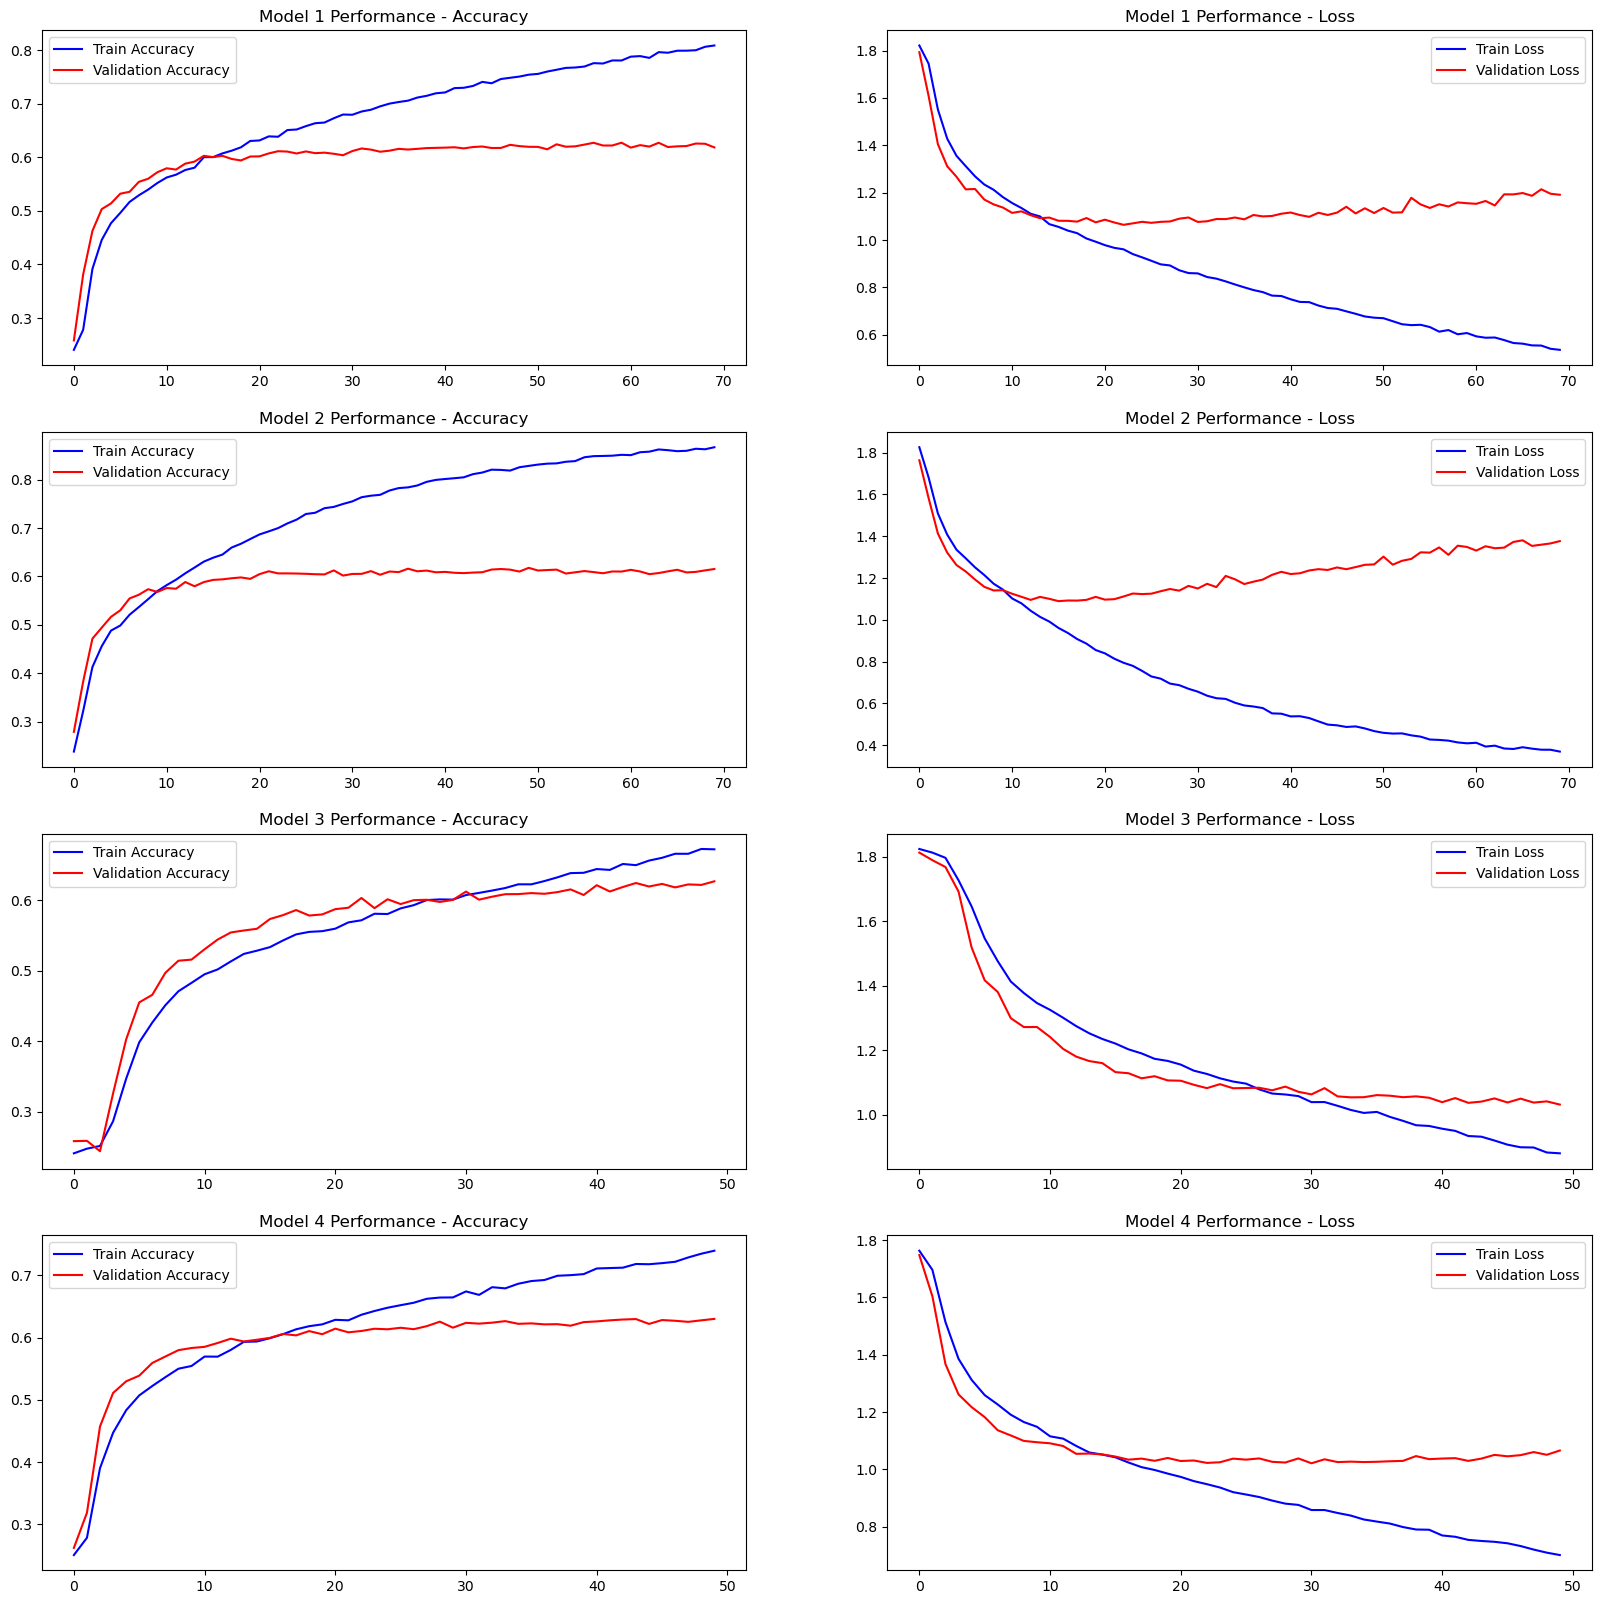

In [62]:
plt.figure(figsize=(20,20))

n_rows = len(perf_stats['history'])
plt_pos = 1

for i, history in enumerate(perf_stats['history']):
    ## plotting the train-test loss

    accuracy = history.history['accuracy']
    accuracy_val = history.history['val_accuracy']
    num_epochs = range(len(accuracy))

    plt.subplot(n_rows,2,plt_pos)
    plt.plot(num_epochs, accuracy, 'b', label='Train Accuracy')
    plt.plot(num_epochs, accuracy_val, 'r', label='Validation Accuracy')
    plt.title(f'Model {i+1} Performance - Accuracy')
    plt.legend()

    loss = history.history['loss']
    loss_validation = history.history['val_loss']

    plt.subplot(n_rows,2,plt_pos+1)
    plt.plot(num_epochs, loss, 'b', label='Train Loss')
    plt.plot(num_epochs, loss_validation, 'r', label='Validation Loss')
    plt.title(f'Model {i+1} Performance - Loss')
    plt.legend()
    
    plt_pos += 2

plt.show()

Save Objects

In [ ]:
# Save Model
model.save("FacialExpressionModel.h5")

In [ ]:
# Save Label Encoder 
import pickle

def save_object(obj , name):
    pickle_obj = open(f"{name}.pck","wb")
    pickle.dump(obj, pickle_obj)
    pickle_obj.close()

In [ ]:
save_object(Le, "LabelEncoder")